In [1]:
import sqlite3
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import SimpleITK as sitk

params = {
    # 'backend': 'Agg',
    'axes.labelsize'  : 15.5,
    "font.family": "sans-serif",
    'axes.titlesize'  : 'medium',
    'font.size'       : 14,
    'legend.fontsize' : 14,
    'xtick.labelsize' : 'small',
    'ytick.labelsize' : 'small'
}
plt.rcParams.update(params)

# tex_fonts = {
#     # Use LaTeX to write all text
#     "text.usetex": True,
#     "font.family": "serif",
#     # Use 10pt font in plots, to match 10pt font in document
#     "axes.labelsize": 14.5,
#     "font.size": 14.5,
#     # Make the legend/label fonts a little smaller
#     "legend.fontsize": 14.5,
#     "xtick.labelsize": 14.5,
#     "ytick.labelsize": 14.5
# }

# plt.rcParams.update(tex_fonts)

plt.rcParams.update({'figure.max_open_warning': 0})

# source: https://scipy-cookbook.readthedocs.io/items/Matplotlib_LaTeX_Examples.html
def get_figsize(columnwidth, wf=0.5, hf=(5.**0.5-1.0)/2.0, ):
    """Parameters:
      - wf [float]:  width fraction in columnwidth units
      - hf [float]:  height fraction in columnwidth units.
                     Set by default to golden ratio.
      - columnwidth [float]: width of the column in latex. Get this from LaTeX
                             using \showthe\columnwidth
    Returns:  [fig_width,fig_height]: that should be given to matplotlib
    """
    fig_width_pt = columnwidth*wf
    inches_per_pt = 1.0/72.27               # Convert pt to inch
    fig_width = fig_width_pt*inches_per_pt  # width in inches
    fig_height = fig_width*hf      # height in inches
    return [fig_width, fig_height]

## *RQ3*: How much do different annotators (dis-)agree with each other w.r.t. their personal perceptions of segmentation quality?

In [2]:
conn = sqlite3.connect('grabcutstudy.db')

grabcut_masks_df = pd.read_sql_query('''select * from interactionswithmask''', conn, parse_dates=['first_interaction_time', 'submission_time'])

conn.close()

computed_masks_dict = np.load('testimages_seg.npz')

In [3]:
def idx_str_to_np_array(x):
    indices = [int(s) for s in x.split(',')]
    mask_array = np.empty((384, 512), dtype=np.uint8).ravel()
    mask_array.fill(0)
    mask_array[indices] = 1
    return mask_array.reshape((384, 512))


grabcut_masks_df['mask_arr'] = grabcut_masks_df['mask'].apply(idx_str_to_np_array)
del grabcut_masks_df['mask']

In [4]:
gt = np.load('kromp_gt.npz')

neurblas5_gt = gt['neurblas5']
neurblas10_gt = gt['neurblas10']
neurblas16_gt = gt['neurblas16']
normal2_gt = gt['normal2']
normal4_gt = gt['normal4']

In [5]:
# grabcut_masks_df.loc[grabcut_masks_df['image_id'] == image_id, ['mask_arr', 'mask_uuid']]

In [6]:
def get_masks(grabcut_masks_df, computed_masks_dict, image_id):
    masks_per_image_df = grabcut_masks_df.loc[grabcut_masks_df['image_id'] == image_id, ['mask_arr', 'mask_uuid']]

    annotator_masks = masks_per_image_df['mask_arr'].values
    annotator_masks_uuids = masks_per_image_df['mask_uuid'].values
    annotator_masks = np.stack(annotator_masks, axis=0)

    computed_masks = computed_masks_dict[image_id][1:]

    return computed_masks, annotator_masks, annotator_masks_uuids

def get_staple_outputs(computed_masks, annotator_masks, annotator_masks_uuids, img_id=None):
    computers = computed_masks.shape[0]
    annotators = annotator_masks.shape[0]

    all_masks = [computed_masks[i].astype(np.uint8) for i in range(computers)] \
                + [annotator_masks[i].astype(np.uint8) for i in range(annotators)]

    sitk_images = [sitk.GetImageFromArray(mask) for mask in all_masks]

    staple_filter = sitk.STAPLEImageFilter()
    seg_estimate = staple_filter.Execute(sitk_images)

    print(f"[*] STAPLE for {img_id}: {staple_filter.GetElapsedIterations()} iterations.")

    # seg_estimate = sitk.GetArrayViewFromImage(result)
    sensitivities = staple_filter.GetSensitivity()
    specificities = staple_filter.GetSpecificity()

    computed_mask_scores = (sensitivities[:computers], specificities[:computers])
    annotator_mask_scores = (sensitivities[computers:], specificities[computers:], annotator_masks_uuids.tolist())

    return seg_estimate, computed_mask_scores, annotator_mask_scores

In [7]:
img_id_ordered = ['lym0', 'lym17', 'neu0', 'neu12', 'neu90', 'agg17', 'agg23', 'agg185', 'neurblas5', 'neurblas10', 'neurblas16', 'normal2', 'normal4']

masks = {}
staple_eval_data = {}

for img_id in img_id_ordered:
    computed_masks, annotator_masks, annotator_masks_uuids = get_masks(grabcut_masks_df, computed_masks_dict, img_id)
    masks[img_id] = {
        'computed_masks': computed_masks,
        'annotator_masks': annotator_masks,
    }

    staple_outputs = get_staple_outputs(computed_masks, annotator_masks, annotator_masks_uuids, img_id)
    staple_eval_data[img_id] = {
        'staple_estimate': staple_outputs[0],
        'computed_mask_scores': {
            'sensitivities': staple_outputs[1][0],
            'specificities': staple_outputs[1][1],
        },
        'annotator_mask_scores': {
            'sensitivities': staple_outputs[2][0],
            'specificities': staple_outputs[2][1],
            'mask_uuid': staple_outputs[2][2],
        },
    }

[*] STAPLE for lym0: 5 iterations.
[*] STAPLE for lym17: 3 iterations.
[*] STAPLE for neu0: 14 iterations.
[*] STAPLE for neu12: 11 iterations.
[*] STAPLE for neu90: 11 iterations.
[*] STAPLE for agg17: 13 iterations.
[*] STAPLE for agg23: 12 iterations.
[*] STAPLE for agg185: 12 iterations.
[*] STAPLE for neurblas5: 10 iterations.
[*] STAPLE for neurblas10: 10 iterations.
[*] STAPLE for neurblas16: 14 iterations.
[*] STAPLE for normal2: 8 iterations.
[*] STAPLE for normal4: 14 iterations.


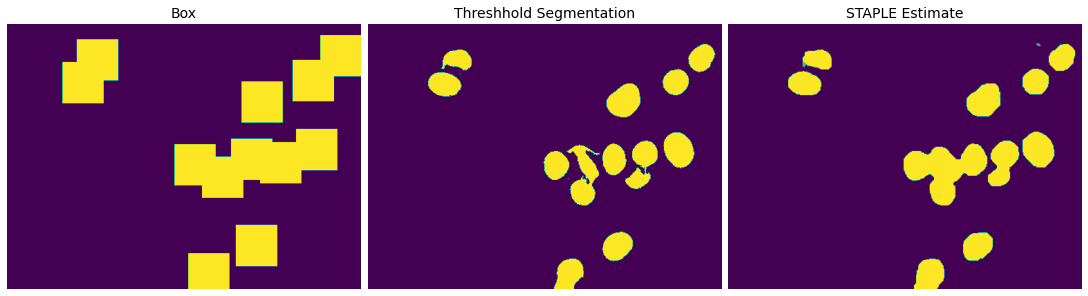

In [8]:
img_id = 'normal4'

fig, axs = plt.subplots(1, 3, figsize=(15,10), constrained_layout=True)

axs[0].set_title(f'Box')
axs[0].imshow(masks[img_id]['computed_masks'][0])
axs[0].axis('off')

axs[1].set_title(f'Threshhold Segmentation')
axs[1].imshow(masks[img_id]['computed_masks'][1])
axs[1].axis('off')

axs[2].set_title(f'STAPLE Estimate')
axs[2].imshow(sitk.GetArrayFromImage(staple_eval_data[img_id]['staple_estimate']))
axs[2].axis('off')

# axs[3].set_title(f'Ground Truth')
# axs[3].imshow(gt[img_id])
# axs[3].axis('off')

plt.show()

In [21]:
img_id_ordered = ['lym0', 'lym17', 'neu0', 'neu12', 'neu90', 'agg17', 'agg23', 'agg185', 'neurblas5', 'neurblas10', 'neurblas16', 'normal2', 'normal4']

annotator_performance_data = []

for img_id in img_id_ordered:
    sensitivities = staple_eval_data[img_id]['annotator_mask_scores']['sensitivities']
    specificities = staple_eval_data[img_id]['annotator_mask_scores']['specificities']
    mask_uuids = staple_eval_data[img_id]['annotator_mask_scores']['mask_uuid']

    for sensitivity, specificity, uuid in zip(sensitivities, specificities, mask_uuids):
        annotator_performance_data.append([img_id, sensitivity, specificity, uuid])

annotator_performance_df = pd.DataFrame(annotator_performance_data, columns=['image_id', 'sensitivity', 'specificity', 'uuid'])
imgs = pd.api.types.CategoricalDtype(ordered=True, categories=img_id_ordered)
annotator_performance_df['image_id'] = annotator_performance_df['image_id'].astype(imgs)

In [22]:
conn = sqlite3.connect('grabcutstudy.db')
images_df = pd.read_sql_query('''select * from images''', conn)
conn.close()

In [23]:
annotator_performance_df = pd.merge(annotator_performance_df, images_df, how='inner', on='image_id')

difficulty_levels = ['Easy', 'Medium', 'Noisy', 'Difficult']
difficulty = pd.api.types.CategoricalDtype(ordered=True, categories=difficulty_levels)
annotator_performance_df['difficulty'] = annotator_performance_df['difficulty'].astype(difficulty)

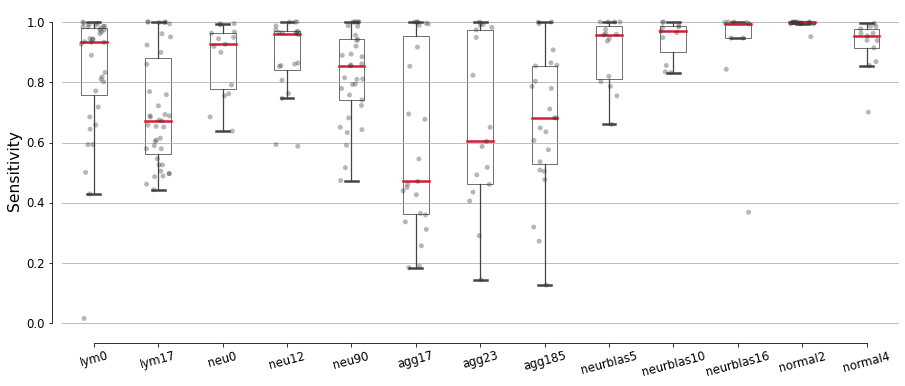

In [10]:
# sns.set_style("ticks")
sns.set_style({
    'xtick.top': False,
    'ytick.right': False,
})

f, ax = plt.subplots(figsize=(15, 6))

PROPS = {
    'boxprops':{'facecolor':'none'},
    'medianprops':{'color':'#d71c33', 'linewidth': 2.5},
    'whiskerprops':{'linewidth': 1.25},
    'capprops':{'linewidth': 2.5}
}

sns.boxplot(x='image_id', y='sensitivity', data=annotator_performance_df, showfliers = False, width=.4, whis=1.8, linewidth=0.75, **PROPS)

sns.stripplot(x='image_id', y='sensitivity', data=annotator_performance_df, size=5, color=".2", alpha=.35, jitter=0.2)

ax.yaxis.grid(True)
ax.set(ylabel="Sensitivity")
ax.set(xlabel="")
sns.despine(offset=10, trim=True)
plt.xticks(rotation=15)
plt.show()
# plt.savefig(f"plots/specificities.png", bbox_inches='tight')

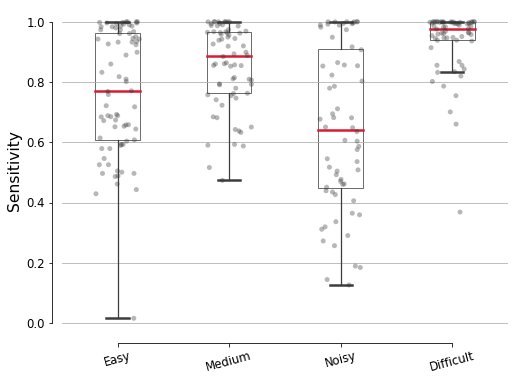

In [24]:
sns.set_style({
    'xtick.top': False,
    'ytick.right': False,
})

f, ax = plt.subplots(figsize=(8, 6))

PROPS = {
    'boxprops':{'facecolor':'none'},
    'medianprops':{'color':'#d71c33', 'linewidth': 2.5},
    'whiskerprops':{'linewidth': 1.25},
    'capprops':{'linewidth': 2.5}
}

sns.boxplot(x='difficulty', y='sensitivity', data=annotator_performance_df, showfliers = False, width=.4, whis=1.8, linewidth=0.75, **PROPS)

sns.stripplot(x='difficulty', y='sensitivity', data=annotator_performance_df, size=5, color=".2", alpha=.35, jitter=0.2)

ax.yaxis.grid(True)
ax.set(ylabel="Sensitivity")
ax.set(xlabel="")
sns.despine(offset=10, trim=True)
plt.xticks(rotation=15)
plt.show()

In [37]:
import Cdf
import Pmf

In [95]:
sensitivities_easy_vals = annotator_performance_df.loc[annotator_performance_df['difficulty'] == 'Easy'].sensitivity.values.tolist()
sensitivities_easy_cdf = Cdf.MakeCdfFromList(sensitivities_easy_vals)
sensitivities_easy_pmf = Pmf.MakePmfFromCdf(sensitivities_easy_cdf)

sensitivities_medium_vals = annotator_performance_df.loc[annotator_performance_df['difficulty'] == 'Medium'].sensitivity.values.tolist()
sensitivities_medium_cdf = Cdf.MakeCdfFromList(sensitivities_medium_vals)
sensitivities_medium_pmf = Pmf.MakePmfFromCdf(sensitivities_medium_cdf)

sensitivities_noisy_vals = annotator_performance_df.loc[annotator_performance_df['difficulty'] == 'Noisy'].sensitivity.values.tolist()
sensitivities_noisy_cdf = Cdf.MakeCdfFromList(sensitivities_noisy_vals)
sensitivities_noisy_pmf = Pmf.MakePmfFromCdf(sensitivities_noisy_cdf)

sensitivities_difficult_vals = annotator_performance_df.loc[annotator_performance_df['difficulty'] == 'Difficult'].sensitivity.values.tolist()
sensitivities_difficult_cdf = Cdf.MakeCdfFromList(sensitivities_difficult_vals)
sensitivities_difficult_pmf = Pmf.MakePmfFromCdf(sensitivities_difficult_cdf)


specificities_easy_vals = annotator_performance_df.loc[annotator_performance_df['difficulty'] == 'Easy'].specificity.values.tolist()
specificities_easy_cdf = Cdf.MakeCdfFromList(specificities_easy_vals)
specificities_easy_pmf = Pmf.MakePmfFromCdf(specificities_easy_cdf)

specificities_medium_vals = annotator_performance_df.loc[annotator_performance_df['difficulty'] == 'Medium'].specificity.values.tolist()
specificities_medium_cdf = Cdf.MakeCdfFromList(specificities_medium_vals)
specificities_medium_pmf = Pmf.MakePmfFromCdf(specificities_medium_cdf)

specificities_noisy_vals = annotator_performance_df.loc[annotator_performance_df['difficulty'] == 'Noisy'].specificity.values.tolist()
specificities_noisy_cdf = Cdf.MakeCdfFromList(specificities_noisy_vals)
specificities_noisy_pmf = Pmf.MakePmfFromCdf(specificities_noisy_cdf)

specificities_difficult_vals = annotator_performance_df.loc[annotator_performance_df['difficulty'] == 'Difficult'].specificity.values.tolist()
specificities_difficult_cdf = Cdf.MakeCdfFromList(specificities_difficult_vals)
specificities_difficult_pmf = Pmf.MakePmfFromCdf(specificities_difficult_cdf)

In [97]:
difficulty_levels = ['Easy', 'Medium', 'Noisy', 'Difficult']
sensitivities_cdfs = [sensitivities_easy_cdf, sensitivities_medium_cdf, sensitivities_noisy_cdf, sensitivities_difficult_cdf]
specificities_cdfs = [specificities_easy_cdf, specificities_medium_cdf, specificities_noisy_cdf, specificities_difficult_cdf]

def cdf_to_concat_df(cdf, category):
    xs, ps = cdf.Render()
    category_list = [category for i in range(len(xs))]
    return pd.DataFrame.from_dict({
        'xs': xs,
        'ps': ps,
        'difficulty': category_list,
    })

sensitivities_cdfs_df = pd.concat([cdf_to_concat_df(c, d) for d, c in zip(difficulty_levels, sensitivities_cdfs)]).reset_index(drop=True)
specificities_cdfs_df = pd.concat([cdf_to_concat_df(c, d) for d, c in zip(difficulty_levels, specificities_cdfs)]).reset_index(drop=True)

In [50]:
print(len(sensitivities_easy_vals))
print(len(sensitivities_medium_vals))
print(len(sensitivities_noisy_vals))
print(len(sensitivities_difficult_vals))

75
68
64
63


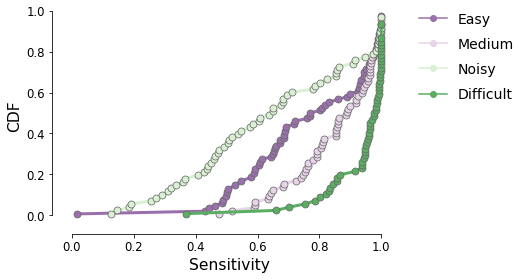

In [115]:
kromp_cmap = sns.color_palette("PRGn", 4)
# sns.palplot(kromp_cmap)

sns.set_style({
    'xtick.top': False,
    'ytick.right': False,
})

f, ax = plt.subplots(figsize=(6, 4))

marker_style={
    'markeredgecolor': 'dimgrey'
}

sns.lineplot(data=sensitivities_cdfs_df, x='xs', y='ps',
             # palette=kromp_cmap,
             dashes=False,
             hue='difficulty', style='difficulty', ci=None, markers=['o', 'o', 'o', 'o'], linewidth=3, markersize=7, palette='PRGn', ax=ax, **marker_style)

# handles, labels = ax.get_legend_handles_labels()
# for ha in handles:
#     ha.set_edgecolor("dimgrey")
#
# lgd = ax.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., labelspacing=0.8, frameon=False)

# for legend_handle in ax.get_legend().legendHandles:
#     legend_handle._legmarker.set_markeredgewidth(1)
#     legend_handle._legmarker.set_markeredgecolor('dimgrey')
#     legend_handle.set_edgecolor('dimgrey')

l = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., labelspacing=0.8, frameon=False)

# ax.yaxis.grid(True)
ax.set(ylabel="CDF")
ax.set(xlabel="Sensitivity")
sns.despine(offset=10, trim=True)
# plt.xticks(rotation=15)

plt.show()

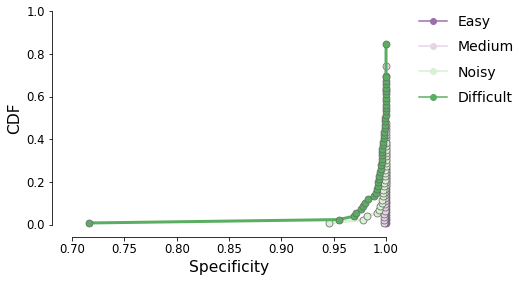

In [114]:
kromp_cmap = sns.color_palette("PRGn", 4)
# sns.palplot(kromp_cmap)

sns.set_style({
    'xtick.top': False,
    'ytick.right': False,
})

f, ax = plt.subplots(figsize=(6, 4))

ax.set_xlim([0.69, 1.01])
ax.set_ylim([-0.01, 1.01])

marker_style={
    'markeredgecolor': 'dimgrey'
}

sns.lineplot(data=specificities_cdfs_df, x='xs', y='ps',
             # palette=kromp_cmap,
             dashes=False,
             hue='difficulty', style='difficulty', ci=None, markers=['o', 'o', 'o', 'o'], linewidth=3, markersize=7, palette='PRGn', ax=ax, **marker_style)

# ax.set_xscale("log")

# handles, labels = ax.get_legend_handles_labels()
# for ha in handles:
#     ha.set_edgecolor("dimgrey")
#
# lgd = ax.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., labelspacing=0.8, frameon=False)

# for legend_handle in ax.get_legend().legendHandles:
#     legend_handle._legmarker.set_markeredgewidth(1)
#     legend_handle._legmarker.set_markeredgecolor('dimgrey')
#     legend_handle.set_edgecolor('dimgrey')

l = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., labelspacing=0.8, frameon=False)

# ax.yaxis.grid(True)
ax.set(ylabel="CDF")
ax.set(xlabel="Specificity")
sns.despine(offset=10, trim=True)

plt.show()

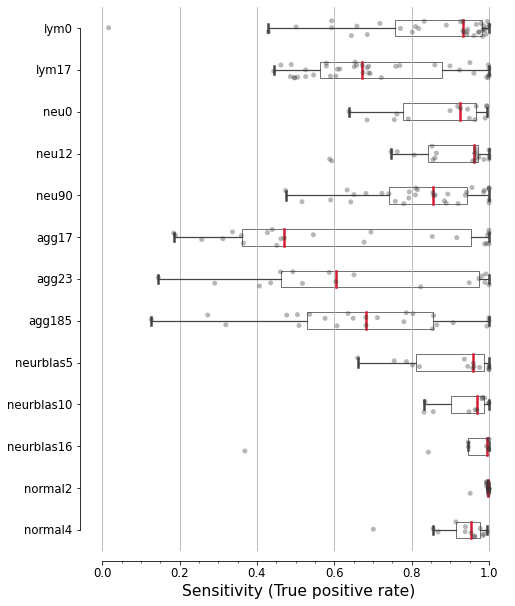

<Figure size 432x288 with 0 Axes>

In [11]:
# sns.set_style("ticks")
sns.set_style({
    'xtick.top': False,
    'ytick.right': False,
})

f, ax = plt.subplots(figsize=(7.5, 10))

PROPS = {
    'boxprops':{'facecolor':'none'},
    'medianprops':{'color':'#d71c33', 'linewidth': 2.5},
    'whiskerprops':{'linewidth': 1.25},
    'capprops':{'linewidth': 2.5}
}

sns.boxplot(y='image_id', x='sensitivity', data=annotator_performance_df, showfliers = False, width=.4, whis=1.8, linewidth=0.75, **PROPS)

sns.stripplot(y='image_id', x='sensitivity', data=annotator_performance_df, size=5, color=".2", alpha=.35, jitter=0.2)

ax.xaxis.grid(True)
ax.get_xaxis().set_minor_locator(ticker.AutoMinorLocator())
ax.set(xlabel="Sensitivity (True positive rate)")
ax.set(ylabel="")
# ax.set_xlim([0, 620])
sns.despine(offset=10, trim=True)
# plt.xticks(rotation=15)
plt.show()
plt.savefig(f"plots/all_sensitivities.png", bbox_inches='tight')

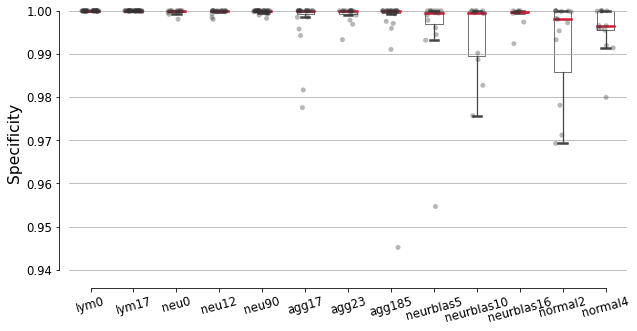

<Figure size 432x288 with 0 Axes>

In [12]:
sns.set_style({
    'xtick.top': False,
    'ytick.right': False,
})

# f, ax = plt.subplots(figsize=get_figsize(418.25555, wf=1.0))
f, ax = plt.subplots(figsize=(10, 5))

PROPS = {
    'boxprops':{'facecolor':'none'},
    'medianprops':{'color':'#d71c33', 'linewidth': 2.5},
    'whiskerprops':{'linewidth': 1.25},
    'capprops':{'linewidth': 2.5}
}

sns.boxplot(x='image_id', y='specificity', data=annotator_performance_df, showfliers = False, width=.4, whis=1.8, linewidth=0.75, **PROPS, ax=ax)

sns.stripplot(x='image_id', y='specificity', data=annotator_performance_df, size=5, color=".2", alpha=.35, jitter=0.2, ax=ax)

ax.set_ylim([0.938, 1.001])
# ax.set_yscale("log")
ax.yaxis.grid(True, which="both")
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
# ax.minorticks_off()
ax.set_yticks(np.arange(0.94, 1.0, step=0.01))

ax.set(ylabel="Specificity")
ax.set(xlabel="")
ax.spines['left'].set_visible(True)
sns.despine(offset=10, trim=True)
plt.xticks(rotation=15)
plt.show()

plt.savefig(f"plots/all_specificities.png", bbox_inches='tight')

KeyError: 'computed_masks'

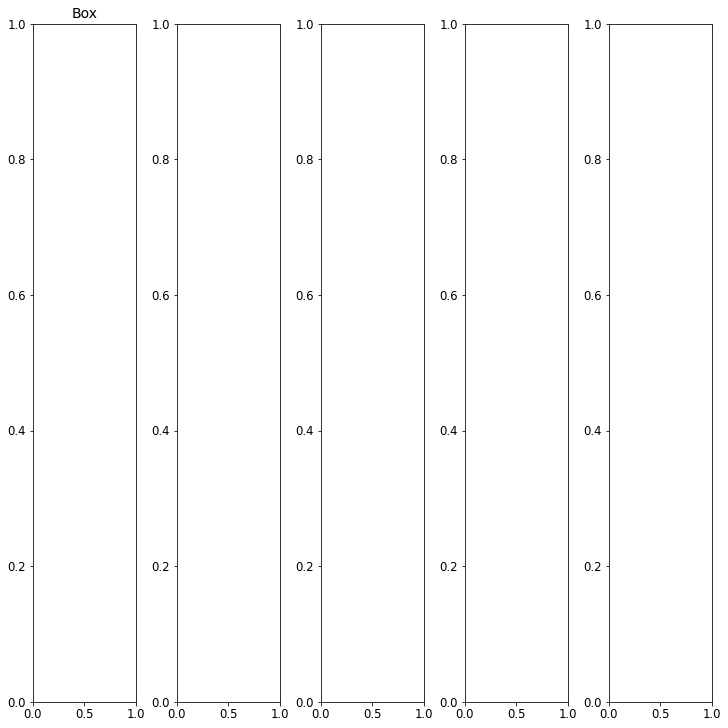

In [13]:
fig, axs = plt.subplots(1, 5, figsize=(10,10), constrained_layout=True)

axs[0].set_title(f'Box')
axs[0].imshow(staple_eval_data['neurblas5']['computed_masks'][0])
axs[0].axis('off')

axs[1].imshow(staple_eval_data['neurblas5']['computed_masks'][1])
axs[2].axis('off')

axs[3].set_title(f'STAPLE Estimate')
axs[3].imshow(staple_eval_data['neurblas5']['staple_estimate'])
axs[3].axis('off')

axs[2].set_title(f'Ground Truth')
axs[2].imshow(neurblas5_gt)
axs[2].axis('off')

plt.show()

In [ ]:
# staple_neurblas5_df = pd.DataFrame.from_dict(
#     {
#         'Bounding Box Segmentation': [round(sensitivities[0], 3), round(specificities[0], 3)],
#         'Adaptive Threshhold': [round(sensitivities[1], 3), round(specificities[1], 3)],
#         'All annotators (median)': [round(sens_m, 3), round(spec_m, 3)],
#     },
#     orient='index',
#     columns=['Sensitivity', 'Specificity']
# )
#
# staple_neurblas5_df

In [ ]:
def compute_mean_iou_for_predictions(predictions, groundtruth):
    i = np.logical_and(predictions, groundtruth)
    u = np.logical_or(predictions, groundtruth)
    return np.sum(i) / np.sum(u)

In [ ]:
fig, axs = plt.subplots(1, 5, figsize=(10,10), constrained_layout=True)

axs[0].imshow(staple_eval_data['neurblas5']['computed_masks'][1])
axs[0].axis('off')

axs[1].set_title(f'STAPLE Estimate\n IoU={compute_mean_iou_for_predictions(neurblas5_est, neurblas5_gt)}')
axs[1].imshow(staple_eval_data['neurblas5']['staple_estimate'])
axs[1].axis('off')

axs[2].set_title(f'Ground Truth')
axs[2].imshow(neurblas5_gt)
axs[2].axis('off')

plt.show()

In [ ]:
# --- Your data, e.g. results per algorithm:
data1 = [5,5,4,3,3,5]
data2 = [6,6,4,6,8,5]
data3 = [7,8,4,5,8,2]
data4 = [6,9,3,6,8,4]
data6 = [17,8,4,5,8,1]
data7 = [6,19,3,6,1,1]


# --- Combining your data:
data_group1 = [data1, data2, data6]
data_group2 = [data3, data4, data7]
data_group3 = [data1, data1, data1]
data_group4 = [data2, data2, data2]
data_group5 = [data2, data2, data2]

data_groups = [data_group1, data_group2, data_group3] #, data_group4] #, data_group5]

# --- Labels for your data:
labels_list = ['a','b', 'c']
width       = 0.1
xlocations  = [ x*((1+ len(data_groups))*width) for x in range(len(data_group1)) ]

symbol      = 'r+'
ymin        = min ( [ val  for dg in data_groups  for data in dg for val in data ] )
ymax        = max ( [ val  for dg in data_groups  for data in dg for val in data ])

fig, ax = plt.subplots(figsize=(10, 6))
ax.set_ylim(ymin,ymax)

ax.grid(True, linestyle='dotted')
ax.set_axisbelow(True)

plt.xlabel('X axis label')
plt.ylabel('Y axis label')
plt.title('title')

space = len(data_groups)/2
offset = len(data_groups)/2


ax.set_xticks( xlocations )
ax.set_xticklabels( labels_list, rotation=0 )
# --- Offset the positions per group:

group_positions = []
for num, dg in enumerate(data_groups):
    _off = (0 - space + (0.5+num))
    print(_off)
    group_positions.append([x-_off*(width+0.01) for x in xlocations])

for dg, pos in zip(data_groups, group_positions):
    plt.boxplot(dg,
               sym=symbol,
               #            labels=['']*len(labels_list),
               labels=['']*len(labels_list),
               positions=pos,
               widths=width,
               #           notch=False,
               #           vert=True,
               #           whis=1.5,
               #           bootstrap=None,
               #           usermedians=None,
               #           conf_intervals=None,
               #           patch_artist=False,
               )



plt.show()